# Network Science model in Jupiter Notebook with Netwokx


<img src="materials/image_bipartite.png">

## Imports and class definitions

In [1]:
# Imports
import os,glob
import numpy as np
import networkx as nx
import pandas as pd
import random, string, time
import pylab
import collections
from natsort import natsorted
from matplotlib import pyplot as plt
import imageio
%matplotlib inline
from IPython import display
from IPython.display import clear_output
import io,pickle
# import urllib, base64
try:
    import randomnames
    rndnames_imported = True
except:
    rndnames_imported = False

#Classes and methods

def randInt(maxn=100, minn=0):
    return minn + np.random.randint(maxn-minn, size=1)[0]

def randStr(stringLength=10, kind=None):
    if kind is None or rndnames_imported is False:
        letters = string.ascii_lowercase
        return ''.join(random.choice(letters) for i in range(stringLength))
    elif kind.lower()=='name':
        return random.choice(randomnames.NAMES).title() + ' '+random.choice(randomnames.SURNAMES).title()
    else: #if kind.lower()=='book':
        return random.choice(randomnames.ADJECTIVES).title() + ' '+random.choice(randomnames.NOUNS).title()        

def getLogicChoice(options):
    array = [x for x in options for y in range(options[x])]
    random.shuffle(array)
    if bool(array):
        return random.choice(array)
    else:
        return None
def decision(probability):
    return random.random() < probability
    
def random_dates(start, end, n=10):
    start_u = start.value//10**9
    end_u = end.value//10**9
    return pd.to_datetime(np.random.randint(start_u, end_u, n), unit='s')
# random_dates(start=pd.to_datetime('2015-01-01'), end=pd.to_datetime('2019-06-14'))


def save_plot(name):
    if not os.path.exists('plots'):
        os.mkdir('plots')    
    plt.savefig('plots/{}.png'.format(name))
    
def clear_folder(path='plots/*'):
    files = glob.glob(path)
    for file in files:
        os.remove(file)
        
def folder2gif(path='plots/*', filename='simulation.gif'):        

    images = []
    files = natsorted(glob.glob(path))
    for i,file in enumerate(files):
        images.append(imageio.imread(file))
        print("{}/{} frames drawn".format(i+1,len(files)), end='\r')
    if len(images)>0:
        imageio.mimsave(filename, images)   
        
def get_opinion(a=1, b=-1, p=0.52):
    return random.random()*2-1
#     return a if random.uniform(0,1) < p else b 
            
            
def plotGraph(epoch, ax, lastreads=[], draw_labels=True, draw_empty=False, draw_legend=True):

    global nodePositions
    nodePositions = nx.spring_layout(G, pos=nodePositions, iterations=1) 

    nodes_0 = [nid for nid in G.nodes if G.nodes[nid]['bipartite'] == 0]    
    nodes_1 = [nid for nid in G.nodes if G.nodes[nid]['bipartite'] == 1]    
    
    if not draw_empty:
        nodes_0 = [nid for nid in nodes_0 if len(G.nodes[nid]['opinions'])>0]
        nodes_1 = [nid for nid in nodes_1 if G.nodes[nid]['initialized']]

    ax.set_title("Network (Size={}, ActiveAgents={}), epoch = {}".format(len(df_books), len([nid for nid in nodes_1 if G.nodes[nid]['active']]), epoch))
    plt.axis('off')
    if draw_legend:
        plotLegend = {
            'Inactive User':'grey', 
            'Active User':'blue',
            'Activated User':'cyan',
            'Unliked Book':'red',
            'Neutral Book':'yellow',
            'Liked Book':'green',
            'Unread Book':'gray', 
        }

        for label, color in plotLegend.items():
            ax.plot([0],[0],color=color,label=label)
        ax.axis('off') 
        plt.legend(loc='upper right')
    
    gnodes_0 = nx.draw_networkx_nodes(G, 
        pos=nodePositions, 
        node_color = [G.nodes[nid]['color'] for nid in G.nodes if nid in nodes_0], 
        node_size = [int(np.sqrt(1+len(G.nodes[nid]['opinions']))*3e+3/(2*params['n_books'])) for nid in G.nodes if nid in nodes_0], #[i*(100*25/params['n_books']) for i in Network.node_sizes],
    #     node_size = 25,
        nodelist = nodes_0, 
        alpha = 0.7,
        ax=ax)
    gnodes_1 = nx.draw_networkx_nodes(G, 
        pos = nodePositions,
        node_color = [G.nodes[nid]['color'] for nid in G.nodes if nid in nodes_1],
        node_size = [int(np.sqrt(1+len(G.nodes[nid]['reads']))*3e+3 /(4*params['n_agents'])) for nid in G.nodes if nid in nodes_1],  
    #     node_size = 15,                              
        nodelist = nodes_1, 
        alpha = 0.7,
        node_shape='v',
        ax=ax)
    gedges = nx.draw_networkx_edges(G, 
        pos=nodePositions,
        edge_color='black',
        alpha = 0.1,
        ax=ax)  
    gedges_last = nx.draw_networkx_edges(G, 
        pos=nodePositions,
        edge_color='b',
        width=3,
        alpha = 0.5,
        edgelist=lastreads,
        ax=ax)
    if draw_labels:
        labels = {nid:nid for nid in nodes_0+nodes_1}
        glabels = nx.draw_networkx_labels(G,
            pos={nd:nodePositions[nd]+[0.00,-0.0] for nd in nodePositions},
            alpha = 0.4,
            font_size = 8,
            labels = labels,
            ax=ax)
        
# CSV operations        
def generateBookCSV(n=1, filename='results/Books.CSV'):
    header = ['BookId', 'BookName', 'Cost']
    books = [] 
    for i in range(n):
        books.append(['book'+str(i), randStr(kind='book'), randInt(maxn=100, minn=1)])    
    df_books = pd.DataFrame(data=books, columns=header)
    
    folder = os.path.split(filename)[:-1][0]            
    if not os.path.exists(folder):
        os.makedirs(folder)        
    df_books.to_csv( filename , index=False ) 
    return df_books

def generateUserCSV(n=1, filename='results/Users.CSV'):
    header = ['UserId', 'UserName'] 
    users = [] 
    for i in range(n):
        users.append(['user'+str(i), randStr(kind='name')])    
    df_users = pd.DataFrame(data=users, columns=header)
    
    folder = os.path.split(filename)[:-1][0]            
    if not os.path.exists(folder):
        os.makedirs(folder)        
    df_users.to_csv( filename , index=False ) 
    return df_users

def saveUserCSV(filename='results/Users.CSV'):     
    df_users.to_csv( filename , index=False )
    
def saveBookCSV(filename='results/Books.CSV'):     
    df_books.to_csv( filename , index=False )
        
# add a user outside of csv
def add_user_outsideCSV():
#     global df_users
    df_users.loc['user'+str(len(df_users))] = [randStr(kind='name')]
    G.add_node(user, bipartite=1, shape='v', color=(0.5,0.5,0.5), size=1e+3 * 4/params['n_books'], reads = [], active=False, initialized=False)

# add a book outside of csv
def add_book_outsideCSV():
#     global df_books
    df_books.loc['book'+str(len(df_books))] = [randStr(kind='book'), randInt(maxn=100, minn=1)]
    G.add_node(book, bipartite=0, shape='o', color=(0.5,0.5,0.5), size=1e+3 * 4/params['n_books'], opinions = [])   
    
class READS:
    def __init__(self):
        self.header = ['Timestamp','BookId', 'UserID', 'Cost', 'Feedback']
        self.reads = []  
    def addRead(self, t, bid, uid, cost, feedback):  
        self.reads.append((t, bid, uid, cost, feedback))
    def getDataFrame(self):
        return pd.DataFrame(data=self.reads, columns=self.header) 

## Parameters

In [2]:
### Parameters

params = {
    'n_books' : 50, # Number of Nodes in the Graph
    'n_agents' : 250, # Number of Agents (Actions per epoch, each agent trails its own path)
    'n_agents_init': 10, # Number of Agents at the simulation begining
    'seed' : None, # Integer seed number or None
    'epochs': 100, # Number of epochs
#     'n_plot_treshold' : 250, # A treshold for number of nodes. If there are more nodes than this, then simplified visualiztion will be used
#     'updatable_plot': True, # display with updating plot by each epoch OR display whole epochs set to None to disable any plots
}
# params['epochs'] = int(0.1*params['n_books']*params['n_agents'])

# Probabilities for an event happening at each event
# The values must be integers. There is onle one of those will be triggered by a single agent per epoch

# There is a single event1 each epoch for every active agent
event1 = {
    'alpha': 20, # P for adding a new node connected to an existing node chosen randomly 
                    # according to the in-degree distribution
    'beta': 20, # P for adding an edge between two exisiting nodes. 
                    # One existing node is chosen randomly - according to the in-degree distribution 
                    # and the other chosen randomly according to the out-degree distribution.
#     'gamma': 20, # P for adding a new node connected to an exsisting node chosen randomly 
                  # according to the out-degree distribution
    'delta_in': 20, # Bias for choosing nodes from degree distribution.
    'delta_out':20 # Bias for choosing nodes from out-degree distribution.
} 

# event2 hapens right after event1. every type happens once per epoch except 'eta'
event2 = {
    'epsilon': 0, # P for no event
    'zeta': 15,# P for a new agent at a random node
    'eta': 25, # P for an agent inviting a new agent (should also be influenced by a node's feedback)
    'theta': 10, # P for adding a new book
    'iota': 0, # P for activating a non-active user
    'kappa': 30 # P for deactivating an active user - there is a higher probability of retirement if more active
}
random.seed(params['seed'])
np.random.seed(params['seed'])


### Generating CSV files with random books and users

file_users ='results/Users.CSV'
file_books = 'results/Books.CSV'

df_users = generateUserCSV(n=params['n_agents'], filename=file_users).set_index('UserId')
df_books = generateBookCSV(n=params['n_books'], filename=file_books).set_index('BookId')
df_books

,BookName,Cost
BookId,,
book0,Colorful Bear,36
book1,Reassured Paper,39
book2,Grubby Corn,10
book3,Combative Duck,15
book4,Minute Shoe,30
book5,Whopping Horse,57
book6,Icy Seed,48
book7,Frightened Party,48
book8,Substantial Top,57


## Simulation

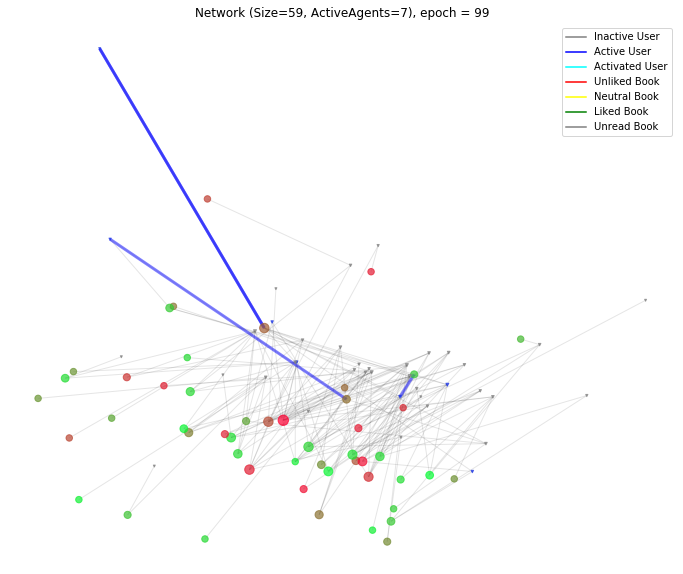

In [3]:
### Graph initialization


import networkx as nx
from networkx.algorithms import bipartite

random.seed(params['seed'])
np.random.seed(params['seed'])

G = nx.complete_bipartite_graph(0,0)

for book in df_books.to_dict()['BookName'].keys():
    G.add_node(book, bipartite=0, shape='o', color=(0.5,0.5,0.5), size=1e+3 * 4/params['n_books'], opinions = [])

for user in df_users.to_dict()['UserName'].keys():
    G.add_node(user, bipartite=1, shape='v', color=(0.5,0.5,0.5), size=1e+3 * 4/params['n_books'], reads = [], active=False, initialized=False)

# Initial agents: set active state to agents
if params['n_agents_init']>0:
    for uid in random.sample(list(df_users.index), params['n_agents_init']):
        G.nodes[uid]['initialized'] = True    
        G.nodes[uid]['active'] = True 

Reads = READS()
lastreads = []


### Simulation


clear_folder()
    
fig, ax = plt.subplots(figsize=(12, 10))
plt.axis('off') 
nodePositions = nx.spring_layout(G, iterations=100) 

# Simulation loop
epochTimes = []
Growth_books = {}
Growth_users = {}

for epoch in range(params['epochs']):  
    now = time.time()
#     print('epoch',epoch)
    
    bookList = [nid for nid in G.nodes if G.nodes[nid]['bipartite']==0]
    userList = [nid for nid in G.nodes if G.nodes[nid]['bipartite']==1]  
    lastreads = []
    
    # Event 1
#     print('\tevent 1')
    for uid in userList:
        if G.nodes[uid]['active'] and G.nodes[uid]['initialized']:
            choice1 = getLogicChoice(event1)
            
            if choice1 == 'alpha':
                read = getLogicChoice(options={node:degree+1 for node,degree in G.degree if degree==0 and node in bookList})
            elif choice1 == 'beta':
                read = getLogicChoice(options={node:degree+1 for node,degree in G.degree if degree>0 and node in bookList})
#             elif choice1 == 'gamma':
#                 uid_choice = getLogicChoice(options={node:degree+1 for node,degree in G.degree if degree==0 and node in userList})
#                 read = getLogicChoice(options={node:degree+1 for node,degree in G.degree if degree==0 and node in bookList})
            elif choice1 == 'delta_in':
                read = getLogicChoice(options={node:degree+1 for node,degree in G.degree if node in bookList})
            elif choice1 == 'delta_out':
                uid_choice = getLogicChoice(options={node:degree+1 for node,degree in G.degree if node in userList})
                read  = getLogicChoice(options={node:len([op for op in G.nodes[node]['opinions'] if op>=0]) for node in G.nodes[uid_choice]['reads']})
            else:
                read = None
                
            if read != None and read not in G.nodes[uid]['reads']: 
                lastreads.append((uid,read))
                G.nodes[uid]['color'] = (0.1,0.2,0.9) #'blue'
                G.add_edge(uid, read)
                
                G.nodes[uid]['reads'].append(read)
                feedback = get_opinion()
                G.nodes[read]['opinions'].append(feedback)
                whole_fb = np.mean(G.nodes[read]['opinions'])  
                coef_color = 0.9*float(abs(whole_fb))
                G.nodes[read]['color'] = (0.9,0.9,0.2) if coef_color==0.0 else ((1-coef_color,coef_color,0.2) if whole_fb>0 else (coef_color,1-coef_color,0.2))
                
                Reads.addRead(epoch, read, uid, df_books.loc[read].Cost, feedback)               
                
                
            if len(G.nodes[uid]['reads']) / params['n_books'] >= 0.9:
                G.nodes[uid]['active'] = False
                
    
    # Event 2   
#     print('\tevent 2')
    choice2 = getLogicChoice(event2)
    
    if choice2 == 'epsilon':
        None
        
    elif choice2 == 'zeta':        
        uid_invited = getLogicChoice(options={uid:1 for uid in userList if not G.nodes[uid]['initialized'] and not G.nodes[uid]['active'] } )
        if uid_invited: 
            G.nodes[uid_invited]['initialized'] = True
            G.nodes[uid_invited]['active'] = True
            G.nodes[uid_invited]['color'] = 'cyan'
#             print('\t  ', choice2, uid_invited, 'invited')
            
    elif choice2 == 'eta':
        uid_inviter = getLogicChoice(options={uid:len(G.nodes[uid]['reads']) for uid in userList if G.nodes[uid]['active'] } )
        uid_invited = getLogicChoice(options={uid:1 for uid in userList if not G.nodes[uid]['initialized'] and not G.nodes[uid]['active'] } )
        if uid_inviter and uid_invited:
            read = getLogicChoice(options={bid:int(10*(1+np.mean(G.nodes[bid]['opinions']))/2) for bid in G.nodes[uid_inviter]['reads']  if 0<len(G.nodes[bid]['opinions'])})
            if read:
                lastreads.append((uid_invited,read))
                G.nodes[uid_invited]['initialized'] = True
                G.nodes[uid_invited]['active'] = True
                G.nodes[uid_invited]['color'] = (0.1,0.2,0.9) #'blue'
                G.add_edge(uid_invited, read)
                
                G.nodes[uid_invited]['reads'].append(read)
                feedback = get_opinion()
                G.nodes[read]['opinions'].append(feedback)
                whole_fb = np.mean(G.nodes[read]['opinions'])  
                coef_color = 0.9*float(abs(whole_fb))
                G.nodes[read]['color'] = (0.9,0.9,0.2) if coef_color==0.0 else ((1-coef_color,coef_color,0.2) if whole_fb>0 else (coef_color,1-coef_color,0.2))  
                
#                 print('\t  ', choice2, uid_inviter, 'invited',uid_invited, '->', read)
                Reads.addRead(epoch, read, uid_invited, df_books.Cost[read], feedback)
                lastreads.append((uid_invited,read))
                
    elif choice2 == 'theta':
        add_book_outsideCSV()
        
    elif choice2 == 'iota':
        choice_iota = getLogicChoice(options={uid:len(G.nodes[uid]['reads']) for uid in userList if G.nodes[uid]['initialized'] and not G.nodes[uid]['active'] } )
        if not invite is None:
            G.nodes[choice_iota]['active'] = True
            G.nodes[uid_invited]['color'] = (0.1,0.2,0.9)
            
    elif choice2 == 'kappa':        
        choice_kappa = getLogicChoice(options={uid:len(G.nodes[uid]['reads']) for uid in userList if G.nodes[uid]['active'] } )
        if choice_kappa: 
            G.nodes[choice_kappa]['active'] = False
            G.nodes[choice_kappa]['color'] = (0.5,0.5,0.5)
#             print('\t  ', choice2, choice_kappa, 'retired')            
    else:
        None
        
    then = time.time()    
    epochTimes.append(then - now)    
    
    Growth_users[epoch] = [degree for nid,degree in G.degree if degree>0 and nid in userList and G.nodes[nid]['active']]  
    Growth_books[epoch] = [degree for nid,degree in G.degree if degree>0 and nid in bookList]  
        
    # Plotting nodes, edges, labels
    def plotting(spi_adj=0):
        display.clear_output(wait=True) 
        plotGraph(epoch=epoch, ax=ax, lastreads=lastreads, draw_labels=False, draw_empty=False, draw_legend=True)
#         plotGraph(i=i,ax=ax,lastreads=lastreads)
        display.display(pylab.gcf())
        save_plot(str(epoch)+'_'+str(spi_adj))
        plt.cla()
        if epoch >= params['epochs']-1:
            plt.close()  
        
#         print("{}/{} epochs done".format(epoch+1,params['epochs']), end='\r')        
    plotting()        
        
plt.close()  

In [4]:
# Save-update CSV files (as extra entries may be added)

def saveUserCSV(filename='results/Users.CSV'):     
    df_users.to_csv( filename  )
    
def saveBookCSV(filename='results/Books.CSV'):     
    df_books.to_csv( filename  )    
    
saveUserCSV()
saveBookCSV()

In [5]:
# Create a gif from the simulation

if not os.path.exists('results'):
    os.mkdir('results')
folder2gif(filename = os.path.join('results','simulation.gif'))

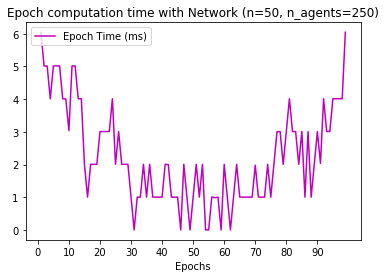

In [6]:
# Simulation speed plot
# Epoch time graph represents the time for each epoch of the simulation, this is to see how long it takes for each epoch to be simulated.

plt.xlabel('Epochs')
plt.plot(np.array(range(len(epochTimes)))[1:], np.array(epochTimes)[1:]/0.001, 'm-', label='Epoch Time (ms)')
pylab.legend(loc='upper left')
plt.title("Epoch computation time with Network (n={}, n_agents={})".format(params['n_books'], params['n_agents']))
plt.xticks([i for i in range(params['epochs']) if i%(params['epochs']/10)==0])
plt.show()

### Pandas dataframe

In [7]:
reads_dataframe = Reads.getDataFrame().sort_values(by=['Timestamp'])

# Assume random datetimes
# create random names within specified time period
def random_dates(start, end, n=10):
    start_u = start.value//10**9
    end_u = end.value//10**9
    return pd.to_datetime(np.random.randint(start_u, end_u, n), unit='s')

rnddates = sorted(random_dates(start=pd.to_datetime('2015-01-01'), end=pd.to_datetime('2019-06-14'), n=len(reads_dataframe['Timestamp'].unique()) ))
mapping_epoch2dates = {k:v for k,v in zip(reads_dataframe['Timestamp'].unique(),rnddates)}

# reads_dataframe
# reads_dataframe['Datetime'] = sorted(random_dates(start=pd.to_datetime('2015-01-01'), end=pd.to_datetime('2019-06-14'), n=len(reads_dataframe) ))
# reads_dataframe.sort_values(by=['Timestamp'])


def applyEpochDateMapping(row):    
    return mapping_epoch2dates[row['Timestamp']]

reads_dataframe['Datetime'] = reads_dataframe.apply(lambda row: applyEpochDateMapping(row), axis=1)
reads_dataframe

,Timestamp,BookId,UserID,Cost,Feedback,Datetime
0,0,book0,user7,36,0.180942,2015-01-23 00:23:31
1,0,book0,user29,36,0.091508,2015-01-23 00:23:31
2,0,book49,user92,14,0.417939,2015-01-23 00:23:31
3,0,book49,user101,14,-0.786413,2015-01-23 00:23:31
4,0,book41,user122,9,0.945620,2015-01-23 00:23:31
5,0,book36,user130,73,-0.952089,2015-01-23 00:23:31
6,0,book0,user211,36,0.146309,2015-01-23 00:23:31
7,0,book32,user226,55,-0.398056,2015-01-23 00:23:31
14,1,book18,user226,43,-0.365574,2015-02-10 07:54:45
13,1,book47,user217,80,0.512080,2015-02-10 07:54:45


#### Write generated data to CSV file

In [8]:
if not os.path.exists('results'):
    os.mkdir('results')      
reads_dataframe.to_csv( os.path.join('results', 'Reads.CSV') , index=False )    

## Analysis plots

#### Plot the final graph

C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


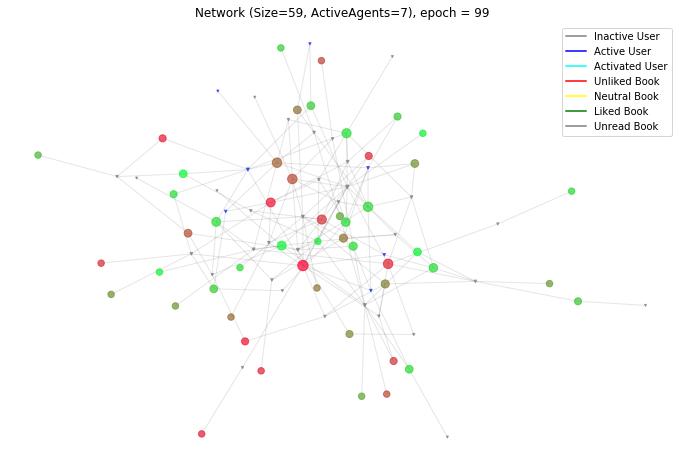

In [9]:
# Final graph

epoch=epoch          
draw_labels=False
draw_empty=False  

nodePositions = nx.spring_layout(G, iterations=20)

nodes_0 = [nid for nid in G.nodes if G.nodes[nid]['bipartite'] == 0]    
nodes_1 = [nid for nid in G.nodes if G.nodes[nid]['bipartite'] == 1]    

if not draw_empty:
    nodes_0 = [nid for nid in nodes_0 if len(G.nodes[nid]['opinions'])>0]
    nodes_1 = [nid for nid in nodes_1 if G.nodes[nid]['initialized']]

fig, ax = plt.subplots(figsize=(12, 8))

plotLegend = {
    'Inactive User':'grey', 
    'Active User':'blue',
    'Activated User':'cyan',
    'Unliked Book':'red',
    'Neutral Book':'yellow',
    'Liked Book':'green',
    'Unread Book':'gray', 
}

for label, color in plotLegend.items():
    ax.plot([0],[0],color=color,label=label)
ax.axis('off')  
    
ax.set_title("Network (Size={}, ActiveAgents={}), epoch = {}".format(len(df_books), len([nid for nid in nodes_1 if G.nodes[nid]['active']]), epoch))
plt.axis('off')
plt.legend(loc='upper right')
# pylab.legend(loc='upper right')

gnodes_0 = nx.draw_networkx_nodes(G, 
    pos=nodePositions, 
    node_color = [G.nodes[nid]['color'] for nid in G.nodes if nid in nodes_0], 
    node_size = [int(np.sqrt(1+len(G.nodes[nid]['opinions']))*3e+3/(2*params['n_books'])) for nid in G.nodes if nid in nodes_0], #[i*(100*25/params['n_books']) for i in Network.node_sizes],
#     node_size = 25,
    nodelist = nodes_0, 
    alpha = 0.7,
    ax=ax)
gnodes_1 = nx.draw_networkx_nodes(G, 
    pos = nodePositions,
    node_color = [G.nodes[nid]['color'] for nid in G.nodes if nid in nodes_1],
    node_size = [int(np.sqrt(1+len(G.nodes[nid]['reads']))*3e+3 /(4*params['n_agents'])) for nid in G.nodes if nid in nodes_1],  
#     node_size = 15,                              
    nodelist = nodes_1,
    alpha = 0.7,
    node_shape='v',
    ax=ax)
gedges = nx.draw_networkx_edges(G, 
    pos=nodePositions,
    edge_color='black',
    alpha = 0.1,
    ax=ax)  

if draw_labels:
    labels = {nid:nid for nid in nodes_0+nodes_1}
    glabels = nx.draw_networkx_labels(G,
        pos={nd:nodePositions[nd]+[0.00,-0.0] for nd in nodePositions},
        alpha = 0.4,
        font_size = 8,
        labels = labels,
        ax=ax)
# plt.show()

#### Rebuilding graph edges for an exact time period using Reads dataframe

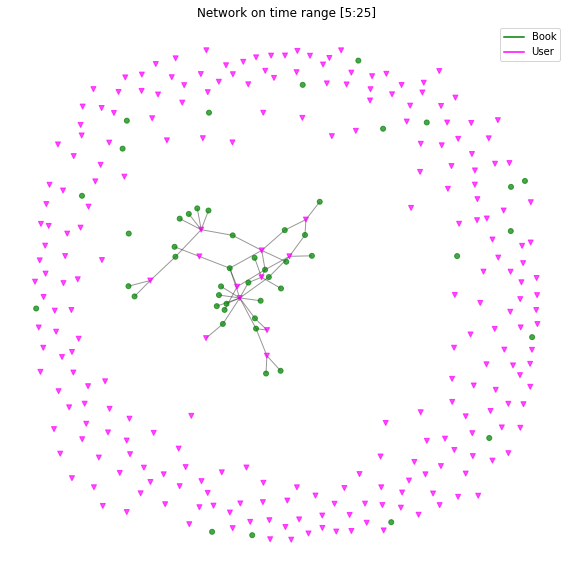

In [10]:
# set start and end epoch here
start_stamp = 5
end_stamp = 25

last_reads = {}

G_tmp = nx.Graph()
G_tmp.add_nodes_from(G)

for row in reads_dataframe.iterrows():
    if row[1]['Timestamp'] >= start_stamp and row[1]['Timestamp'] <= end_stamp:
        if row[1]['UserID'] in last_reads:
            G_tmp.add_edge(row[1]['UserID'], row[1]['BookId']) 
        last_reads.update({row[1]['UserID']: row[1]['BookId']})
               
pos = nx.spring_layout(G_tmp, iterations=15) 

fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("Network on time range [{}:{}]".format(start_stamp, end_stamp))

ax.axis('off')
for label, color in {'Book':'green','User':'magenta'}.items():
    ax.plot([0],[0],color=color,label=label)

plt.legend()
nodes_0 = [nid for nid in G_tmp.nodes if 'book' in nid]
nodes_1 = [nid for nid in G_tmp.nodes if 'user' in nid]

gnodes_0 = nx.draw_networkx_nodes(G_tmp, 
    pos=pos, 
    node_color = ['green' for nid in G_tmp.nodes if nid in nodes_0], 
    node_size = 25,
    nodelist = nodes_0, 
    alpha = 0.7,
    ax=ax)
gnodes_1 = nx.draw_networkx_nodes(G_tmp, 
    pos = pos,
    node_color = ['magenta' for nid in G_tmp.nodes if nid in nodes_1],
    node_size = 25,                              
    nodelist = nodes_1, 
    alpha = 0.7,
    node_shape='v',
    ax=ax)
gedges = nx.draw_networkx_edges(G_tmp, 
    pos=pos,
    edge_color='black',
    alpha = 0.4,
    ax=ax)   
# labels = {nid:nid for nid in nodes_0+nodes_1}
# glabels = nx.draw_networkx_labels(G_tmp, 
#     pos=pos,
#     font_size=8,
#     alpha = 0.4,
#     ax=ax)   


#### Visualization of the resulted graph using Bokeh

In [11]:
import networkx as nx

from bokeh.io import show,  output_notebook
from bokeh.models import Plot, Range1d, MultiLine, Circle, Triangle, Scatter
from bokeh.models import HoverTool, TapTool, BoxSelectTool, BoxZoomTool, ResetTool
from bokeh.models.graphs import from_networkx, NodesAndLinkedEdges, EdgesAndLinkedNodes
from bokeh.palettes import Spectral4
from bokeh.transform import linear_cmap

G2 = nx.Graph()

node_attrs = {}
node_indices=[]
node_shapes=[]
node_colors=[]
for node in G.nodes:    
    G2.add_node(
        node, 
        bipartite = G.nodes[node]['bipartite'], 
        shape = G.nodes[node]['shape'], 
        sentiment = str(np.mean(G.nodes[node]['opinions']) if 'opinions' in G.nodes[node] else 0.0) 
    )
    node_color = 'magenta' if G.nodes[node]['bipartite']==1 else 'green'
    node_attrs[node] = node_color
    node_indices.append(node)
    node_colors.append(node_color)
    node_shapes.append( 'circle' if G.nodes[node]['bipartite']==0 else 'triangle' )
    
for edge in G.edges():    
    G2.add_edge(edge[0],edge[1])    


nx.set_node_attributes(G2, node_attrs, "node_color")
    

plot = Plot(plot_width=640, plot_height=480, x_range=Range1d(-1.1,1.1), y_range=Range1d(-1.1,1.1))
# plot.title.text = "Graph Interaction Demonstration"

node_hover_tool = HoverTool(tooltips=[("index", "@index", ), ("shape", "@shape"), ("sentiment", "@sentiment")])
plot.add_tools(
    ResetTool(), 
    node_hover_tool, 
    BoxZoomTool(),     
    TapTool(),
#     BoxSelectTool()
)

graph_renderer = from_networkx(G2, nx.spring_layout, scale=1.0, center=(0,0))

# graph_renderer.node_renderer.glyph = Circle(size=15, fill_color=Spectral4[0])
# graph_renderer.node_renderer.selection_glyph = Circle(size=15, fill_color=Spectral4[2])
# graph_renderer.node_renderer.hover_glyph = Circle(size=15, fill_color=Spectral4[1])
graph_renderer.node_renderer.data_source.add(node_indices, 'index')
graph_renderer.node_renderer.data_source.add(node_colors, 'color')
graph_renderer.node_renderer.data_source.add(node_shapes, 'marker')
graph_renderer.node_renderer.glyph = Scatter(size=20, fill_color='color', marker='marker')

graph_renderer.edge_renderer.glyph = MultiLine(line_color="#555555", line_alpha=0.8, line_width=2)
graph_renderer.edge_renderer.selection_glyph = MultiLine(line_color="#5555DD", line_width=4)
graph_renderer.edge_renderer.hover_glyph = MultiLine(line_color=Spectral4[1], line_width=2)

graph_renderer.selection_policy = NodesAndLinkedEdges()
# graph_renderer.inspection_policy = EdgesAndLinkedNodes()

plot.renderers.append(graph_renderer)

output_notebook()
show(plot)

Loading BokehJS ...

#### Percentage growth

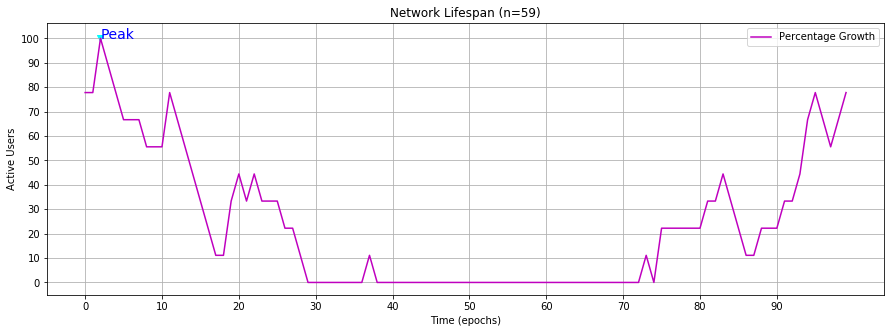

In [12]:
from scipy.optimize import curve_fit

SHOW_PERCENTAGE = True

xData = np.array(list(Growth_books.keys()))#[1:]
yData = np.array([len(e) for e in Growth_books.values()])#[1:]
yData_users = np.array([len(e) for e in Growth_users.values()])#[1:]
if SHOW_PERCENTAGE:
    yData_users = [100*x/max(yData_users) for x in yData_users]
dData = rnddates+rnddates

# plot the data
fig, ax = plt.subplots(figsize=(15,5))
# plt.title('Network Lifespan')
plt.title("Network Lifespan (n={})".format(len(df_books)))
plt.xlabel('Time (epochs)')
plt.ylabel('Active Users')

# ax.plot(xData, yData, 'b-', label='Connected Books')
if SHOW_PERCENTAGE:
    ax.plot(xData, yData_users, 'm-', label='Percentage Growth')
else:
    ax.plot(xData, yData_users, 'm-', label='Active Users')
    
ax.annotate(
    'Peak', 
    xy=(np.argmax(yData_users)*1.02, np.max(yData_users)),
#     xytext=(np.argmax(yData_users)*1.01, np.max(yData_users)*1.01) ,
    size=14, color='blue')
# ax.plot(np.argmax(yData_users), np.max(yData_users), 'r.')

plt.scatter(np.argmax(yData_users), np.max(yData_users), marker='v', color='cyan')
    

ax.grid(True)
pylab.legend(loc='upper right')

# plt.xticks(xData, dData, rotation='80') 
plt.xticks([i for i in range(params['epochs']) if i%(params['epochs']/10)==0], rotation='0')






if SHOW_PERCENTAGE:
    plt.yticks([i for i in range(101) if i%10==0], rotation='0')
    
plt.show()

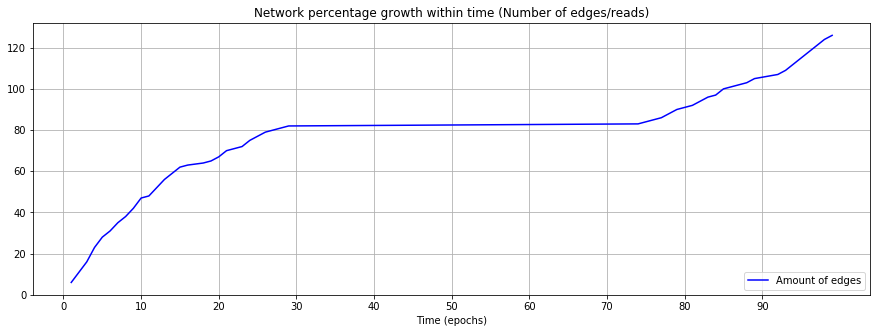

In [13]:
edgesByEpoch = {}
last_reads = {}
totalEdges = 0

for row in reads_dataframe.iterrows():
    if row[1]['UserID'] in last_reads:
        totalEdges+=1
        if row[1]['Timestamp'] in edgesByEpoch:
            edgesByEpoch[row[1]['Timestamp']]+=1            
        else:
            edgesByEpoch[row[1]['Timestamp']]=totalEdges

    last_reads.update({row[1]['UserID']: row[1]['BookId']})

    
yData = np.array([v for (k,v) in edgesByEpoch.items()])
yy = [v for (k,v) in edgesByEpoch.items()]
yData2 = np.array([0.0]+[100*y1/y0 for y0,y1 in zip(yy, yy[1:])])

xData = np.array([k for (k,v) in edgesByEpoch.items()])

fig, ax = plt.subplots(figsize=(15,5))
plt.title('Network percentage growth within time (Number of edges/reads)')
plt.xlabel('Time (epochs)')
# plt.ylabel('Amount of edges / Percentage growth')

ax.plot(xData, yData, 'b-', label='Amount of edges')
# ax.plot(xData, yData2, 'm-', label='Percentage Growth')
# for i, txt in enumerate(yData2):
#     if i%2 != 0:
#         ax.annotate("%.0f %%" %(txt), (xData[i], yData2[i]), rotation=45, size=8)

ax.grid(True)
pylab.legend(loc='lower right')

# plt.xticks(xData, dData, rotation='80') 
plt.xticks([i for i in range(params['epochs']) if i%(params['epochs']/10)==0])
plt.show()

#### Degree distrbution

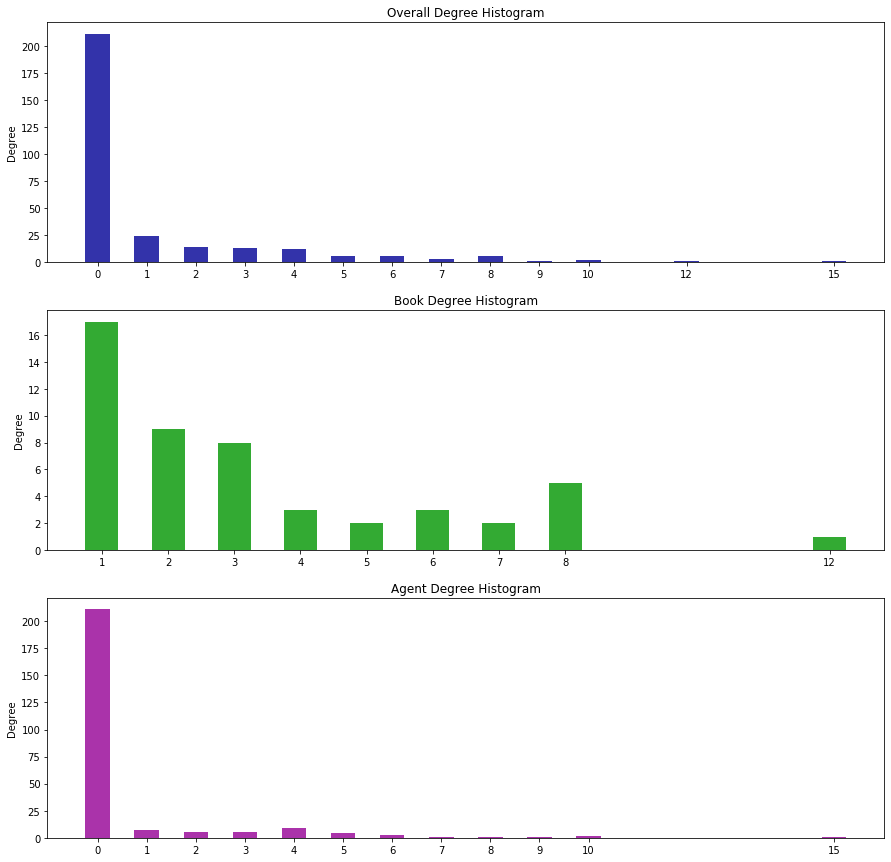

In [14]:
# Plot degree distrbution

import matplotlib.gridspec as gridspec

gs = gridspec.GridSpec(3, 1)
fig, ax = plt.subplots(figsize=(15,5*3))


plt.subplot(gs[0, 0])

degree_sequence = sorted([d for nid, d in G.degree()], reverse=True)  # degree sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

plt.bar(deg, cnt, width=0.50, color='#3333AA')
plt.title("Overall Degree Histogram")
plt.ylabel("Degree")

plt.xticks([d for d in deg])


plt.subplot(gs[1, 0])

degree_sequence = sorted([d for nid, d in G.degree() if G.nodes[nid]['bipartite']==0], reverse=True)  # degree sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

plt.bar(deg, cnt, width=0.50, color='#33AA33')
plt.title("Book Degree Histogram")
plt.ylabel("Degree")

plt.xticks([d for d in deg])

#
plt.subplot(gs[2, 0])

degree_sequence = sorted([d for nid, d in G.degree() if G.nodes[nid]['bipartite']==1], reverse=True)  # degree sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

plt.bar(deg, cnt, width=0.50, color='#AA33AA')
plt.title("Agent Degree Histogram")
plt.ylabel("Degree")

plt.xticks([d for d in deg])

plt.show()